In [1]:
from imblearn.over_sampling import SMOTE
from keras import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras_tuner.tuners import GridSearch
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf

In [2]:
# MLP

In [3]:
# Read data
df = pd.read_csv('dataset_phishing.csv')

features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags', 'nb_hyphens', 'page_rank', 'avg_word_path', 'ratio_extHyperlinks', 'longest_words_raw', 'google_index', 'length_hostname', 'longest_word_host', 'domain_registration_length', 'nb_www', 'nb_underscore', 'nb_dots', 'ratio_extMedia', 'phish_hints', 'domain_in_title', 'web_traffic', 'safe_anchor', 'nb_space', 'shortening_service', 'ip', 'domain_age', 'nb_qm', 'nb_hyperlinks', 'nb_slash']

In [4]:
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df["status"])

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# Handle class imbalance by oversampling the minority class (phishing)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define the MLPClassifier with early stopping to avoid overfitting
mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.15)

# Set up hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(200, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.008],
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Get the best model from the grid search
best_mlp = grid_search.best_estimator_

# Evaluate the model on the validation set
y_val_pred = best_mlp.predict(X_val)

# Calculate performance metrics for the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [6]:
# CNN

In [7]:
# Define a seed value for reproducibility
seed = 42

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

def create_model(filters_1=32, kernel_size_1=3, dropout_rate_1=0.2,
                 filters_2=64, kernel_size_2=3, dropout_rate_2=0.2,
                 dense_units=128, learning_rate=0.001):
    model = Sequential()
    
    # First Conv1D layer
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1,
                     activation='relu', input_shape=(X_train_cnn.shape[1], 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_1))
    
    # Second Conv1D layer
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2,
                     activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_2))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Recall()])
    
    return model

In [8]:
X = df[features]
y = df['status']

# Map the 'status' to numerical labels
label_mapping = {'legitimate': 0, 'phishing': 1}
y = y.map(label_mapping)

# Handle missing values in features if any
X.fillna(0, inplace=True)

# Reshape the data
X_reshaped = X.values

# Perform the split as specified
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)


best_params = {'dense_units': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'filters_1': 32, 'filters_2': 64, 'kernel_size_1': 3, 'kernel_size_2': 2, 'learning_rate': 0.01}

# Create and train the model with best parameters
print("\nTraining final model with best parameters...")
best_cnn = create_model(**best_params)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_recall', patience=5, 
                             restore_best_weights=True, mode='max')

# Train the model
history = best_cnn.fit(
    X_train_cnn, y_train,
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Training final model with best parameters...
Epoch 1/50


C:\Users\User\AppData\Local\Temp\ipykernel_16888\369168224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)
D:\anaconda3\envs\testing\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8992 - loss: 0.2736 - recall: 0.8864 - val_accuracy: 0.9113 - val_loss: 0.2300 - val_recall: 0.8471
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9290 - loss: 0.1908 - recall: 0.9218 - val_accuracy: 0.9376 - val_loss: 0.1649 - val_recall: 0.9160
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9374 - loss: 0.1739 - recall: 0.9281 - val_accuracy: 0.9417 - val_loss: 0.1571 - val_recall: 0.9312
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9389 - loss: 0.1635 - recall: 0.9372 - val_accuracy: 0.9475 - val_loss: 0.1548 - val_recall: 0.9510
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9405 - loss: 0.1566 - recall: 0.9384 - val_accuracy: 0.9399 - val_loss: 0.1609 - val_recall: 0.9312
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9472 - loss: 0.1463 - recall: 0.9434 - val_accuracy: 0.9457 - val_loss: 0.1543 - val_recall: 0.9498
Epoch 7/50
251/

In [9]:
# LSTM

In [10]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

#Reshape features with 1 timestep to fit into RNN
X_reshaped = X_scaled.reshape((X.shape[0],1,X.shape[1]))  

le = LabelEncoder()
y = le.fit_transform(df["status"])
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#Define model to fir into GridSearch later
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Choice('units',[128,512,1024,2048]), activation=hp.Choice('activation',['relu','tanh']),input_shape=(1,X.shape[1]))) #4 Different layer sizes
    model.add(Dropout(hp.Float('dropout',0.1,0.5,step=0.1))) #5 different dropout values
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

best_lstm = Sequential()
best_lstm.add(LSTM(1024, activation='relu',input_shape=(1,X.shape[1]))) 
best_lstm.add(Dropout(0.1))
best_lstm.add(Dense(1, activation='sigmoid'))
best_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = best_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val,y_val))

y_pred = (best_lstm.predict(X_test) > 0.5)

print(f"Accuracy: {accuracy_score(y_test,y_pred):.4f}")
print(f"Precision: {precision_score(y_test,y_pred):.4f}")
print(f"Recall:  {recall_score(y_test,y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test,y_pred):.4f}")
print(f"ROC_AUC Score: {roc_auc_score(y_test,y_pred):.4f}")
print(classification_report(y_test, y_pred))

D:\anaconda3\envs\testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9109 - loss: 0.3214 - val_accuracy: 0.9452 - val_loss: 0.1545
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9444 - loss: 0.1454 - val_accuracy: 0.9463 - val_loss: 0.1436
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9518 - loss: 0.1277 - val_accuracy: 0.9510 - val_loss: 0.1370
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9555 - loss: 0.1169 - val_accuracy: 0.9516 - val_loss: 0.1337
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9590 - loss: 0.1100 - val_accuracy: 0.9539 - val_loss: 0.1308
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.9650
Precision: 0.9672
Recall:  0.9627
F1 Score: 0.9649
ROC_AUC Score: 0.9650
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       858
           1       0.97      0.96      0.96       857

    accuracy                           0.97      1715
   macro

In [11]:
# Hard Voting Ensemble Model

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Ensemble Model Performance Metrics:
Accuracy: 0.9668
Precision: 0.9598
Recall: 0.9743
F1 Score: 0.9670
ROC AUC Score: 0.9668


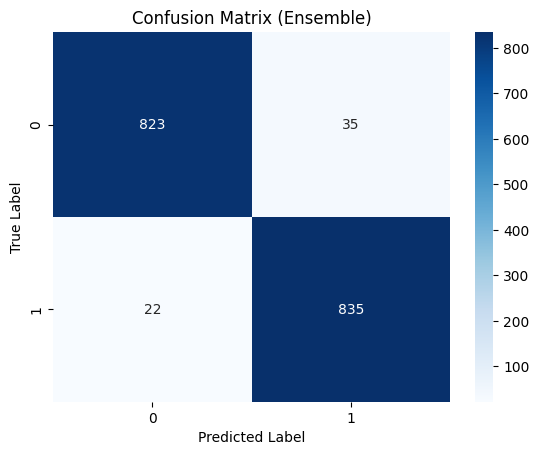

Classification Report (Ensemble):
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       858
           1       0.96      0.97      0.97       857

    accuracy                           0.97      1715
   macro avg       0.97      0.97      0.97      1715
weighted avg       0.97      0.97      0.97      1715



In [12]:
# Make predictions with each model on the test set
y_pred_mlp = best_mlp.predict(X_test.reshape(X_test.shape[0], -1))  # MLP model expects 2D input
y_pred_cnn = best_cnn.predict(X_test_cnn).ravel()  # CNN model prediction
y_pred_lstm = best_lstm.predict(X_test).ravel()  # LSTM model prediction

# Threshold CNN and LSTM predictions
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Combine predictions in a matrix
predictions = np.column_stack((y_pred_mlp, y_pred_cnn, y_pred_lstm))

# Majority voting: get the mode (most common prediction) for each sample across the models
y_pred_ensemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)

# Calculate and display performance metrics
accuracy = accuracy_score(y_test, y_pred_ensemble)
precision = precision_score(y_test, y_pred_ensemble)
recall = recall_score(y_test, y_pred_ensemble)
f1 = f1_score(y_test, y_pred_ensemble)
roc_auc = roc_auc_score(y_test, y_pred_ensemble)

print("Ensemble Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
ensemble_conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Ensemble)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report (Ensemble):\n", classification_report(y_test, y_pred_ensemble))